# Title: Fake News Detection
<b>Team:</b>  
Michelle Amaral  
Esthove Stephen Jeyaraj  
Paul M. Washburn  

# Project Outline
<ul>
    <li>Import Libraries</li>
    <li>Datasets</li>
    <li>Exploratory Analysis</li>
    <li>Data Pre-Processing</li>
    <li>Model 1: Baseline Model Using LinearSVC and Universal Sentence Embeddings</li>
    <li>Model 2: Baseline Model with Autoencoder enhanced Feature Set</li>
    <li>Model 3: Baseline Model with POS tagged Feature Set</li>
    <li>Model 4: Neural Network with LSTM</li>
    <li>Model 5: Neural Network with LSTM and CNN</li>
    <li>Model 6: Neural Network with LSTM, CNN and Glove Word Embeddings</li>
    <li>Best Model: Baseline Model with TfidfVectorizer as Feature Set</li>
</ul>

# Import Libraries

In [ ]:
# To be installed
!pip install --quiet tensorflow_hub
!pip install --quiet yellowbrick
!pip install --quiet spacy[cuda90]
!python -m spacy download en_core_web_sm


In [1]:
# Keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

# Tensorflow
import tensorflow as tf
import tensorflow_hub as hub

## Plot
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import matplotlib as plt

# NLTK
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Spacy
import spacy
spacy.prefer_gpu()
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

#Sklearn
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Other
import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.manifold import TSNE
from time import time

import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)

print("Tensorflow is installed and is version: ",  tf.__version__)
print("Keras is installed and is version: ", tf.keras.__version__)

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Tensorflow is installed and is version:  1.10.0
Keras is installed and is version:  2.1.6-tf


# Datasets

### Dataset 1: Kaggle Fake News
https://www.kaggle.com/c/fake-news/data

In [2]:
df1 = pd.read_csv('data/train.csv')
df1 = df1[pd.notnull(df1['title'])]
df1 = df1[pd.notnull(df1['text'])]
df1.reset_index(drop=True, inplace=True)
print("Dataset 1:", df1.shape)
df1.head()

Dataset 1: (20203, 5)


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


0 = Reliable
1 = Unreliable


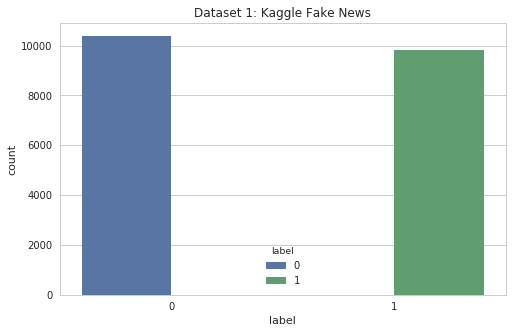

In [3]:
# Target label counts
plt.rcParams['figure.figsize'] = (8, 5)
ax = sns.countplot(x='label', data=df1, hue='label')
ax.set_title("Dataset 1: Kaggle Fake News")
print("0 = Reliable")
print("1 = Unreliable")

### Dataset 2: PolitiFact

https://www.cs.ucsb.edu/~william/software.html
https://www.cs.ucsb.edu/~william/data/liar_dataset.zip

In [4]:
df2 = pd.read_csv('data/train.tsv', sep='\t', names=['id', 'label', 'text', 'subject', 'speaker', 
                                                    'job_title', 'state', 'party', 'barely_true', 'false_counts', 
                                                    'half_true', 'mostly_true', 'fire_counts', 'context'])
print("Dataset 2:", df2.shape)
df2.head()

Dataset 2: (10240, 14)


,id,label,text,subject,speaker,job_title,state,party,barely_true,false_counts,half_true,mostly_true,fire_counts,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


0 = Reliable
1 = Unreliable


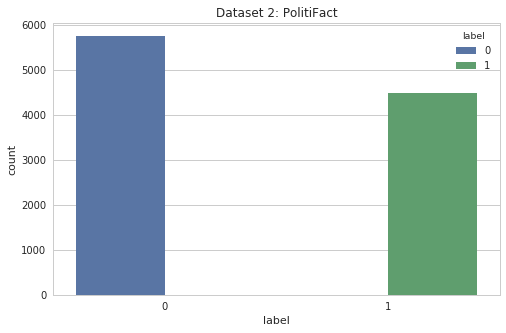

In [5]:
# Target label counts
df2['label'] = np.where((df2['label'] == 'true') | (df2['label'] == 'mostly-true') | (df2['label'] == 'half-true'), 0, 1)
ax = sns.countplot(x='label', data=df2, hue='label')
ax.set_title("Dataset 2: PolitiFact")
print("0 = Reliable")
print("1 = Unreliable")

# Exploratory Analysis

### Select Dataset

In [6]:
df = df1[['title', 'text', 'label']]
print("Dimension:", df.shape)
df.head()

Dimension: (20203, 3)


,title,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1


### Visualize Labels with `TSNEVisualizer` on `title` of News Articles

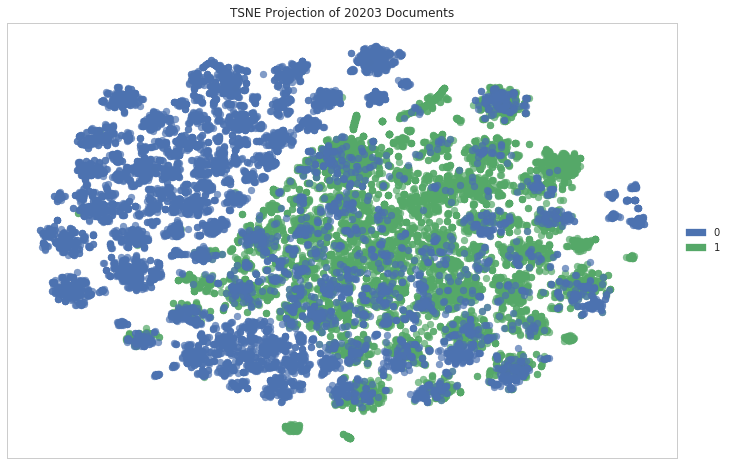

In [44]:
from yellowbrick.text import TSNEVisualizer

# set default figsize
plt.rcParams['figure.figsize'] = (15, 8)

tfidf = TfidfVectorizer(ngram_range=(1,3), min_df=3)
docs = tfidf.fit_transform(df['title']) 
labels = df.label

tsne = TSNEVisualizer()
tsne.fit(docs, labels)
tsne.poof()

### Visualize Labels with `KMeansClusters` on `text` of News Articles

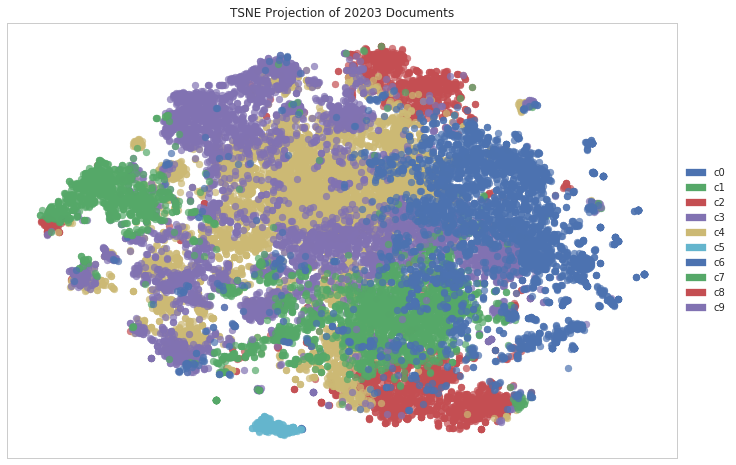

In [45]:
from sklearn.cluster import KMeans

# transform combined_text
tfidf = TfidfVectorizer(ngram_range=(1,3), min_df=3, max_features=1000)
docs = tfidf.fit_transform(df['text']) 

# derive clusters
clusters = KMeans(n_clusters=10)
clusters.fit(docs)

tsne = TSNEVisualizer()
tsne.fit(docs, ["c{}".format(c) for c in clusters.labels_])
tsne.poof()

# Data Pre-Processing

In [7]:
def basic_clean(text):
    text = str(text)
    
    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub('((?:www|https?)(://)?[^\s]+)', " ", text)

    text = text.split()
    
    # Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    
    return text

In [12]:
def fetch_universal_sentence_embeddings(messages, verbose=0):
    """Fetches universal sentence embeddings from Google's
    research paper https://arxiv.org/pdf/1803.11175.pdf.
    
    INPUTS:
    RETURNS:
    """
    module_url = "https://tfhub.dev/google/universal-sentence-encoder/2"

    # Import the Universal Sentence Encoder's TF Hub module
    embed = hub.Module(module_url)

    with tf.Session() as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        message_embeddings = session.run(embed(messages))
        embeddings = list()
        for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
            if verbose:
                print("Message: {}".format(messages[i]))
                print("Embedding size: {}".format(len(message_embedding)))
                message_embedding_snippet = ", ".join(
                    (str(x) for x in message_embedding[:3]))
                print("Embedding: [{}, ...]\n".format(message_embedding_snippet))
            embeddings.append(message_embedding)
    return embeddings

In [16]:
def binary_confusion_matrix(y, y_hat, as_pct=False, verbose=True):
    cm = pd.DataFrame(confusion_matrix(y, y_hat),
                      columns=['(+) actual', '(-) actual'],
                      index=['(+) predicted', '(-) predicted'])
    if as_pct:
        cm = cm / cm.sum().sum()

    P = cm['(+) actual'].sum()
    N = cm['(-) actual'].sum()
    total = P + N
    TP = cm.loc['(+) predicted', '(+) actual']
    FP = cm.loc['(+) predicted', '(-) actual']
    TN = cm.loc['(-) predicted', '(-) actual']
    FN = cm.loc['(-) predicted', '(+) actual']
    TPR = TP / (TP + FN)          # recall/sensitivity
    TNR = TN / (TN + FP)   # specificity
    FPR = FP / (FP + TN)   # fall-out
    FNR = FN / (FN + TP)   # miss rate
    PPV = TP / (TP + FP)   # precision
    NPV = TN / (TN + FN)   # neg predictive value

    if verbose:
        print('''
        Condition Positive:                        %i
        Condition Negative:                        %i
        Total Observations:                        %i

        True Positive:                             %i
        True Negative:                             %i
        False Positive:                            %i
        False Negative                             %i

        True Positive Rate (recall):               %.2f%%
        True Negative Rate (specificity):          %.2f%%
        False Positive Rate (fall-out):            %.2f%%
        False Negative Rate (miss rate):           %.2f%%

        Positive Predictive Value (precision):     %.2f%%
        Negative Predictive Value:                 %.2f%%
        ''' %(P, N, total,
             TP, TN, FP, FN,
             TPR*100, TNR*100, FPR*100, FNR*100,
             PPV*100, NPV*100))

    metrics = {'P': P, 'N': N, 'total': total,
              'TP': TP, 'FP': FP, 'TN': TN, 'FN': FN,
              'TPR': TPR, 'TNR': TNR, 'FPR': FPR, 'FNR': FNR, 'PPV': PPV, 'NPV': NPV}

    return cm, metrics

# Model 1: Baseline Model Using LinearSVC and Universal Sentence Embeddings  
In general, [Universal Sentence Embeddings](https://arxiv.org/pdf/1803.11175.pdf) do best with shorter sequences (e.g. sentences are preferred to paragraphs).  For this reason the text for each article's `title` was used to produce the 512 length sentence embeddings.  An initial grid-search was performed over orders of magnitude on the `C` parameter of the `LinearSVC` and subsequently refined.  The SVC model was chosen for its reputation of performing well on text data and is meant to be a baseline model. 

In [10]:
# Fetch sentence embeddings
title_txt = df['title'].apply(basic_clean).astype(str).tolist()
main_txt = df['text'].apply(basic_clean).astype(str).tolist()

In [14]:
start = time()
embeddings = fetch_universal_sentence_embeddings(title_txt)
print("Completed in %0.3fs" % (time() - start))

embeddings[0][:10]

INFO:tensorflow:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/2'.
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 8.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 18.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 28.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 58.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 68.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 88.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 98.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 108.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2: 118.00MB
INFO:tensorflow:Downloading https://tfhub.dev/google/universal-sentence-encoder/2

[0.05570795014500618,
 -0.0325547493994236,
 -0.057942356914281845,
 0.002557051135227084,
 -0.07265116274356842,
 -0.0028087696991860867,
 0.0738309994339943,
 -0.02396317757666111,
 -0.047740381211042404,
 -0.02884182706475258]

In [15]:
X, y = np.array(embeddings), df.label.values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, random_state=7)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=.5, random_state=7)

In [16]:
# test LinearSVC model as baseline
start = time()
params = {'clf__C':[10], # Tried [.001, .01, .1, 1, 10, 100, 1000] # Best [10]
          'clf__random_state': [777]}

pipeline = Pipeline([
    ('clf', LinearSVC())
])

grid = GridSearchCV(pipeline, params, cv=5, verbose=1)

grid.fit(X_train, y_train)
print("Completed in %0.3fs" % (time() - start))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.5s finished


Completed in 36.605s


In [17]:
grid.best_estimator_

Pipeline(memory=None,
     steps=[('clf', LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=777, tol=0.0001,
     verbose=0))])

In [18]:
yhat_val = grid.predict(X_val)
val_acc = accuracy_score(y_val, yhat_val)
yhat_train = grid.predict(X_train)
train_acc = accuracy_score(y_train, yhat_train) 

print(f'''
Training Accuracy: {round(train_acc, 4)}
Validation Accuracy: {round(val_acc, 4)}
''')

_, __ = binary_confusion_matrix(y_val, yhat_val)
_


Training Accuracy: 0.9026
Validation Accuracy: 0.8795


        Condition Positive:                        1524
        Condition Negative:                        1506
        Total Observations:                        3030

        True Positive:                             1363
        True Negative:                             1302
        False Positive:                            204
        False Negative                             161

        True Positive Rate (recall):               89.44%
        True Negative Rate (specificity):          86.45%
        False Positive Rate (fall-out):            13.55%
        False Negative Rate (miss rate):           10.56%

        Positive Predictive Value (precision):     86.98%
        Negative Predictive Value:                 89.00%
        


,(+) actual,(-) actual
(+) predicted,1363,204
(-) predicted,161,1302


# Model 2: Baseline Model with Autoencoder enhanced Feature Set

In [61]:
X, y = np.array(title_txt), df.label.values
txt_train, txt_test, y_train, y_test = train_test_split(X, y, train_size=.7, random_state=7)

num_words = 5000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(title_txt)

X_train = tokenizer.texts_to_sequences(txt_train)
X_test = tokenizer.texts_to_sequences(txt_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(txt_train[2][:50])
print(X_train[2][:50])

FOR SALE: Hillary's State Department
[12, 2781, 1486, 38, 763]


In [62]:
maxlen = 5000

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

### Build and Save Encoder

The architecture of this autoencoder is constrained down to 50 computational nodes at its center.  Then, only the encoder part of the model is saved and used for encoding.

In [63]:
activation = 'relu'
batch_size = 128

model = Sequential()
model.add(Dense(maxlen, input_dim=maxlen, activation=activation))
model.add(BatchNormalization())
model.add(Dense(2500, activation=activation))
model.add(Dense(500, activation=activation))
model.add(Dense(50, activation=activation))
model.add(Dense(500, activation=activation))
model.add(Dense(2500, activation=activation))
model.add(BatchNormalization())
model.add(Dense(maxlen, activation=activation))

model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])
model.summary()

early = EarlyStopping(patience=3)

history = model.fit(X_train, X_train,
                    epochs=100,
                    verbose=2,
                    validation_data=(X_test, X_test),
                    batch_size=batch_size,
                    callbacks=[early])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 5000)              25005000  
_________________________________________________________________
batch_normalization_3 (Batch (None, 5000)              20000     
_________________________________________________________________
dense_15 (Dense)             (None, 2500)              12502500  
_________________________________________________________________
dense_16 (Dense)             (None, 500)               1250500   
_________________________________________________________________
dense_17 (Dense)             (None, 50)                25050     
_________________________________________________________________
dense_18 (Dense)             (None, 500)               25500     
_________________________________________________________________
dense_19 (Dense)             (None, 2500)              1252500   
__________

In [64]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

Training Accuracy: 0.8777
Testing Accuracy:  0.8830


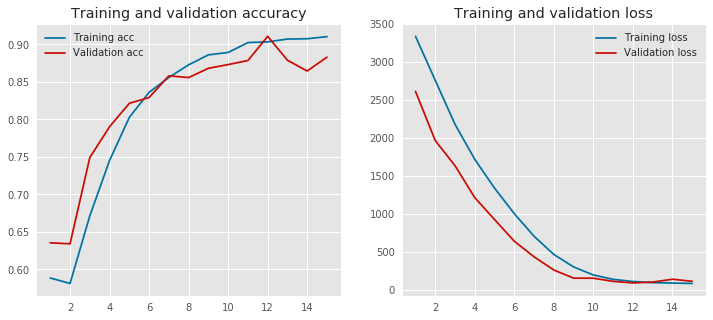

In [65]:
loss, accuracy = model.evaluate(X_train, X_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, X_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

### Test Encoder Transformation as Input to `LinearSVC` Classifier

In [66]:
model = Model(input = model.layers[0].input, output = model.layers[4].output)
X_train_enc = model.predict(X_train)
X_test_enc = model.predict(X_test)
X_test_enc, X_val_enc, y_test, y_val = train_test_split(X_test_enc, y_test, train_size=.5)

In [67]:
start = time()

params = {'clf__C':[.001], # Tried [.001, .01, .1, 1, 10, 100, 1000] # Best [0.001]
          'clf__random_state': [777]}

pipeline = Pipeline([
    ('clf', LinearSVC())
])

grid = GridSearchCV(pipeline, params, cv=5, verbose=1)

grid.fit(X_train_enc, y_train)

print("Completed in %0.3fs" % (time() - start))

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.2min finished


Completed in 73.829s


In [68]:
grid.best_estimator_

Pipeline(memory=None,
     steps=[('clf', LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=777, tol=0.0001,
     verbose=0))])

In [69]:
yhat_val = grid.predict(X_val_enc)
val_acc = accuracy_score(y_val, yhat_val)
yhat_train = grid.predict(X_train_enc)
train_acc = accuracy_score(y_train, yhat_train) 

print(f'''
Training Accuracy: {round(train_acc, 4)}
Validation Accuracy: {round(val_acc, 4)}
''')

_, __ = binary_confusion_matrix(y_val, yhat_val)
_


Training Accuracy: 0.5209
Validation Accuracy: 0.5153


        Condition Positive:                        2991
        Condition Negative:                        40
        Total Observations:                        3031

        True Positive:                             1536
        True Negative:                             26
        False Positive:                            14
        False Negative                             1455

        True Positive Rate (recall):               51.35%
        True Negative Rate (specificity):          65.00%
        False Positive Rate (fall-out):            35.00%
        False Negative Rate (miss rate):           48.65%

        Positive Predictive Value (precision):     99.10%
        Negative Predictive Value:                 1.76%
        


,(+) actual,(-) actual
(+) predicted,1536,14
(-) predicted,1455,26


# Model 3: Baseline Model with POS tagged Feature Set

In [7]:
from nltk import word_tokenize, pos_tag, pos_tag_sents

#tag part of speech
statements = df['text'].tolist()
tagged_statements = pos_tag_sents(map(word_tokenize, statements))

df['POS'] = tagged_statements
df.head()

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,title,text,label,POS
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1,"[(House, NNP), (Dem, NNP), (Aide, NNP), (:, :)..."
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0,"[(Ever, RB), (get, VB), (the, DT), (feeling, N..."
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1,"[(Why, WRB), (the, DT), (Truth, NN), (Might, N..."
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1,"[(Videos, NNP), (15, CD), (Civilians, NNPS), (..."
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1,"[(Print, NNP), (An, DT), (Iranian, JJ), (woman..."


In [8]:
#isolate tags for each article
df['Tags'] = [[tag for word, tag in sent] for sent in df['POS']]
df['Tags'] = df['Tags'].apply(', '.join)
df['Tags'] = df['Tags'].str.lower()
df.head()

,title,text,label,POS,Tags
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1,"[(House, NNP), (Dem, NNP), (Aide, NNP), (:, :)...","nnp, nnp, nnp, :, prp, nnp, nnp, vbd, rb, nnp,..."
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0,"[(Ever, RB), (get, VB), (the, DT), (feeling, N...","rb, vb, dt, nn, prp$, nn, vbz, dt, nn, rb, in,..."
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1,"[(Why, WRB), (the, DT), (Truth, NN), (Might, N...","wrb, dt, nn, nnp, nnp, prp, vbd, nnp, cd, ,, c..."
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1,"[(Videos, NNP), (15, CD), (Civilians, NNPS), (...","nnp, cd, nnps, vbn, in, nnp, nnp, nnp, vbp, nn..."
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1,"[(Print, NNP), (An, DT), (Iranian, JJ), (woman...","nnp, dt, jj, nn, vbz, vbn, vbn, to, cd, nns, i..."


In [10]:
X, y = df['text'].values, df.label.values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, random_state=7)

In [11]:
#countvectorizer and tf-idf on training data
cv = CountVectorizer(vocabulary=['cc', 'cd', 'dt', 'ex', 'fw', 'in', 'jj', 'jjr',
                                 'jjs', 'ls', 'md', 'nn', 'nns', 'nnp', 'nnps', 'pdt', 
                                 'pos', 'prp', 'prp$', 'rb', 'rbr', 'rbs', 'rp', 'to',
                                 'uh', 'vb', 'vbd', 'vbg', 'vbn', 'vbp', 'vbz', 'wdt', 
                                 'wp', 'wp$', 'wrb'])
train_counts = cv.fit_transform(X_train)
train_counts.shape

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer(use_idf=False)
train_tfidf = tfidf_transformer.fit_transform(train_counts)
train_tfidf.shape

(14142, 35)

In [12]:
#countvectorizer and tf-idf on test data
test_counts = cv.fit_transform(X_test)
test_counts.shape

test_tfidf = tfidf_transformer.fit_transform(test_counts)
test_tfidf.shape

(6061, 35)

In [13]:
start = time()

params = {'clf__C':[.001],
          'clf__random_state': [777]}

pipeline = Pipeline([
    ('clf', LinearSVC())
])

grid = GridSearchCV(pipeline, params, cv=5, verbose=1)

grid.fit(train_tfidf, y_train)

print("Completed in %0.3fs" % (time() - start))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Completed in 0.125s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


In [14]:
grid.best_estimator_

Pipeline(memory=None,
     steps=[('clf', LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=777, tol=0.0001,
     verbose=0))])

In [17]:
yhat_test = grid.predict(test_tfidf)
test_acc = accuracy_score(y_test, yhat_test)

print(f'''
Testing Accuracy: {round(test_acc, 4)}
''')

_, __ = binary_confusion_matrix(y_test, yhat_test)
_


Testing Accuracy: 0.5753


        Condition Positive:                        4931
        Condition Negative:                        1130
        Total Observations:                        6061

        True Positive:                             2722
        True Negative:                             765
        False Positive:                            365
        False Negative                             2209

        True Positive Rate (recall):               55.20%
        True Negative Rate (specificity):          67.70%
        False Positive Rate (fall-out):            32.30%
        False Negative Rate (miss rate):           44.80%

        Positive Predictive Value (precision):     88.18%
        Negative Predictive Value:                 25.72%
        


,(+) actual,(-) actual
(+) predicted,2722,365
(-) predicted,2209,765


# Model 4: Neural Network with LSTM

In [50]:
df['text'] = df['text'].apply(basic_clean)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [51]:
df.head(10)

,title,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: Didn Even See Comey Letter Unt...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get feeling life circles roundabout rathe...,0
2,Why the Truth Might Get You Fired,"Why Truth Might Get You Fired October 29, 2016...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Videos Civilians Killed Single Airstrike Have ...,1
4,Iranian woman jailed for fictional unpublished...,Print Iranian woman sentenced six years prison...,1
5,Jackie Mason: Hollywood Would Love Trump if He...,"trying times, Jackie Mason Voice Reason. week ...",0
6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,Ever wonder Britain iconic pop pianist gets lo...,1
7,Benoît Hamon Wins French Socialist Party’s Pre...,"PARIS France chose idealistic, traditional can...",0
8,Excerpts From a Draft Script for Donald Trump’...,Donald Trump scheduled make highly anticipated...,0
9,"A Back-Channel Plan for Ukraine and Russia, Co...",week Michael Flynn resigned national security ...,0


### Tokenize Text Data

In [52]:
labels = df['label']

vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(df['text'])

sequences = tokenizer.texts_to_sequences(df['text'])
data = pad_sequences(sequences, maxlen=50)
print(data.shape)

(20203, 50)


### Network Architechture

The network starts with an embedding layer. The layer lets the system expand each token to a more massive vector, allowing the network to represent a word in a meaningful way. The layer takes 20000 as the first argument, which is the size of our vocabulary, and 100 as the second input parameter, which is the dimension of the embeddings. The third parameter is the input_length of 50, which is the length of each comment sequence.

In [53]:
model_lstm = Sequential()
model_lstm.add(Embedding(20000, 100, input_length=50))
model_lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train Model

In [54]:
model_lstm.fit(data, np.array(labels), validation_split=0.4, epochs=3)

Train on 12121 samples, validate on 8082 samples
Epoch 1/3
12121/12121 [==============================] - 56s 5ms/step - loss: 0.3130 - acc: 0.8628 - val_loss: 0.2369 - val_acc: 0.9055
Epoch 2/3
12121/12121 [==============================] - 53s 4ms/step - loss: 0.1047 - acc: 0.9655 - val_loss: 0.2580 - val_acc: 0.8924
Epoch 3/3
12121/12121 [==============================] - 53s 4ms/step - loss: 0.0521 - acc: 0.9814 - val_loss: 0.3490 - val_acc: 0.8995


# Model 5: Neural Network with LSTM and CNN
The LSTM model worked well. One way to speed up the training time is to improve the network adding “Convolutional” layer. Convolutional Neural Networks (CNN) come from image processing. They pass a “filter” over the data and calculate a higher-level representation. They have been shown to work surprisingly well for text, even though they have none of the sequence processing ability of LSTMs.

### Network Architecture

In [55]:
def create_conv_model():
    model_conv = Sequential()
    model_conv.add(Embedding(vocabulary_size, 100, input_length=50))
    model_conv.add(Dropout(0.2))
    model_conv.add(Conv1D(64, 5, activation='relu'))
    model_conv.add(MaxPooling1D(pool_size=4))
    model_conv.add(LSTM(100))
    model_conv.add(Dense(1, activation='sigmoid'))
    model_conv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model_conv 

### Train Model

In [56]:
model_conv = create_conv_model()
model_conv.fit(data, np.array(labels), validation_split=0.4, epochs = 3)

Train on 12121 samples, validate on 8082 samples
Epoch 1/3
12121/12121 [==============================] - 17s 1ms/step - loss: 0.3272 - acc: 0.8434 - val_loss: 0.2364 - val_acc: 0.8962
Epoch 2/3
12121/12121 [==============================] - 14s 1ms/step - loss: 0.0886 - acc: 0.9686 - val_loss: 0.2965 - val_acc: 0.8857
Epoch 3/3
12121/12121 [==============================] - 15s 1ms/step - loss: 0.0175 - acc: 0.9950 - val_loss: 0.4030 - val_acc: 0.8813


# Model 6: Neural Network with LSTM, CNN and Glove Word Embeddings

Glove was trained on a dataset of one billion tokens (words) with a vocabulary of 400 thousand words. The glove has embedding vector sizes, including 50, 100, 200 and 300 dimensions. Choosing 100-dimensional version for our use case  
https://nlp.stanford.edu/projects/glove/

### Get Glove Embeddings 

In [57]:
embeddings_index = dict()
f = open('data/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [58]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocabulary_size, 100))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

### Network Architecture

In [59]:
model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, 100, input_length=50, weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(0.2))
model_glove.add(Conv1D(64, 5, activation='relu'))
model_glove.add(MaxPooling1D(pool_size=4))
model_glove.add(LSTM(100))
model_glove.add(Dense(1, activation='sigmoid'))
model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train Model

In [60]:
model_glove.fit(data, np.array(labels), validation_split=0.4, epochs = 3)

Train on 12121 samples, validate on 8082 samples
Epoch 1/3
12121/12121 [==============================] - 16s 1ms/step - loss: 0.4789 - acc: 0.7647 - val_loss: 0.3582 - val_acc: 0.8415
Epoch 2/3
12121/12121 [==============================] - 13s 1ms/step - loss: 0.3213 - acc: 0.8560 - val_loss: 0.2994 - val_acc: 0.8599
Epoch 3/3
12121/12121 [==============================] - 13s 1ms/step - loss: 0.2641 - acc: 0.8828 - val_loss: 0.2841 - val_acc: 0.8716


# Best Model: Baseline Model with TfidfVectorizer as Feature Set

In [70]:
X, y = df['text'].values, df.label.values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, random_state=7)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=.5, random_state=7)

In [71]:
start = time()

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC())
])

params = {'tfidf__ngram_range': [(1,2)], # Tried [(1,2), (1,3), (1,4)] # Best [(1,2)]
          'clf__C': [.01, .1, 1, 10, 100, 1000]} # Tried [.01, .1, 1, 10, 100, 1000] # Best [()]

grid = GridSearchCV(pipeline, params, cv=3, verbose=1, n_jobs=4)

grid.fit(X_train, y_train)

print("Completed in %0.3fs" % (time() - start))

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed:  8.2min finished


Completed in 540.989s


In [72]:
grid.best_estimator_

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

### Train & Validate Model

In [73]:
yhat_val = grid.predict(X_val)
val_acc = accuracy_score(y_val, yhat_val)
yhat_train = grid.predict(X_train)
train_acc = accuracy_score(y_train, yhat_train) 

print(f'''
Training Accuracy: {round(train_acc, 4)}
Validation Accuracy: {round(val_acc, 4)}
''')

_, __ = binary_confusion_matrix(y_val, yhat_val)
_


Training Accuracy: 1.0
Validation Accuracy: 0.9743


        Condition Positive:                        1589
        Condition Negative:                        1441
        Total Observations:                        3030

        True Positive:                             1539
        True Negative:                             1413
        False Positive:                            28
        False Negative                             50

        True Positive Rate (recall):               96.85%
        True Negative Rate (specificity):          98.06%
        False Positive Rate (fall-out):            1.94%
        False Negative Rate (miss rate):           3.15%

        Positive Predictive Value (precision):     98.21%
        Negative Predictive Value:                 96.58%
        


,(+) actual,(-) actual
(+) predicted,1539,28
(-) predicted,50,1413


### Test Model

In [74]:
yhat_test = grid.predict(X_test)
test_acc = accuracy_score(y_test, yhat_test)

print(f'''
Testing Accuracy: {round(test_acc, 4)}
''')

_, __ = binary_confusion_matrix(y_test, yhat_test)
_


Testing Accuracy: 0.969


        Condition Positive:                        1550
        Condition Negative:                        1481
        Total Observations:                        3031

        True Positive:                             1488
        True Negative:                             1449
        False Positive:                            32
        False Negative                             62

        True Positive Rate (recall):               96.00%
        True Negative Rate (specificity):          97.84%
        False Positive Rate (fall-out):            2.16%
        False Negative Rate (miss rate):           4.00%

        Positive Predictive Value (precision):     97.89%
        Negative Predictive Value:                 95.90%
        


,(+) actual,(-) actual
(+) predicted,1488,32
(-) predicted,62,1449
